In [1]:
from multiDEPF import LoadSingleSample, seed_everything, ModelmultiDEPF, ConvertATACTorchDataset, ConvertRNATorchDataset, PrepscATAC, RunDenoising, PrepscRNA, ConvertRNATorchBatchDataset, ConvertATACTorchBatchDataset
import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans
import datetime
import time
import tracemalloc
import psutil
tracemalloc.start()
process = psutil.Process(os.getpid())
# folder_path = "./data/scRNA/"
output_path = "./output/"
# feature = "human"
original_dir = "/home/fanyi/1_paper/multi_omics/code/Palate_analysis/scScalpChromatin-main/results"
# 获取该文件夹下所有文件
batch_size = 256
imp = False
Denoising = False
pretrain = False
lr:float = 0.0001
seed_everything(1234)
device = "cuda:2"
file1 = "Palate"

/home/fanyi/anaconda3/envs/MyPackage/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(file1)

if not os.path.exists(os.path.join(output_path, file1)):
    os.makedirs(os.path.join(output_path, file1))
if not os.path.exists(os.path.join(output_path, file1)+'/model/'):
    os.makedirs(os.path.join(output_path, file1)+'/model/')
adata_x = LoadSingleSample(original_dir + '/scRNA_data/RNA.h5ad', trans=False)
adata_y = LoadSingleSample(original_dir + '/scATAC_preprocessing/baseline_preprocessing/unfiltered_output/Tile.h5ad', trans=False)

Palate


In [3]:
# adata_y.obs.index = adata_y.obs.index.str.split('#').str[1]
# adata_x.obs.index = adata_x.obs.index.str.split('_').str[2]

print(adata_x.shape)
print(adata_y.shape)

(5990, 32285)
(3934, 263389)


In [4]:
common_indices = adata_y.obs.index.intersection(adata_x.obs.index)

# Subsetting the DataFrames to keep only the common indices
adata_x_common = adata_x.obs.loc[common_indices]
adata_y_common = adata_y.obs.loc[common_indices]
common_indices

Index(['B6E14_5_2#ACTTAGGGTTCGGTAA-1', 'B6E14_5_2#GCGCGATTCACCATTT-1',
       'B6E14_5_2#GGTCTTGAGCTGGACC-1', 'B6E14_5_2#GCTAGTGTCATGTCAA-1',
       'B6E14_5_2#AGGTCAAAGTAGGCGG-1', 'B6E14_5_2#CCGTTGCGTTACAAAC-1',
       'B6E14_5_2#GGCCTCTGTGTTGTAG-1', 'B6E14_5_2#CCGTTATGTCACAGCG-1',
       'B6E14_5_2#GAGGTGAGTGGGTGAA-1', 'B6E14_5_2#GATTGATGTTAGGCGT-1',
       ...
       'B6E13_5_1#CACTTAAAGTAAGTGG-1', 'B6E13_5_1#CGCATGATCCGTGACA-1',
       'B6E13_5_1#GTACTTCGTTGTGACA-1', 'B6E13_5_1#ACAAACTGTGCAATGC-1',
       'B6E13_5_1#CAAGGCTGTGTAATAC-1', 'B6E13_5_1#TTTGGTAAGCTCATAA-1',
       'B6E13_5_1#TGACTCCTCAATTGGC-1', 'B6E13_5_1#CCTATTTAGTTTAACG-1',
       'B6E13_5_1#TACATCAAGGCGAATA-1', 'B6E13_5_1#GGCTTAAGTTGCACGG-1'],
      dtype='object', length=3934)

In [5]:
len(common_indices)

3934

In [5]:
adata_x = adata_x[adata_x.obs_names.isin(common_indices)].copy()
adata_x


AnnData object with n_obs × n_vars = 3934 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [6]:
adata_y = adata_y[adata_y.obs_names.isin(common_indices)].copy()
adata_y

AnnData object with n_obs × n_vars = 3934 × 263389
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'diseaseStatus', 'Clusters'
    var: 'name'

In [7]:
########################
start_time = time.time()  
########################

if Denoising:
    print("Run denoising part on the scRNA dataset.")
    adata = adata_x.copy()
    inx, top_nvars, imputation_data = RunDenoising(adata, TF=False, DenosingModule_Dir=os.path.join(output_path, file1)+'/model/', 
                                                    original_dim=adata.shape[0], im_dim=8, num_epochs = 100, 
                                                    filter_num =5000, batch_size = 256, device = device, 
                                                    imputation=imp, sample_time=1)
    # save inx
    np.save(os.path.join(output_path, file1, file1 + '_inx.npy'), inx)
    # save top_nvars
    np.save(os.path.join(output_path, file1, file1 + '_top_nvars.npy'), top_nvars)
    # save imputation_data
    np.save(os.path.join(output_path, file1, file1 + '_imputation_data.npy'), imputation_data)
    if inx is not None:
        db_0 = adata[:,inx].copy()
    else:
        db_0 = adata
    gene_selection = np.zeros(db_0.shape[1], dtype=bool)
    gene_selection[top_nvars] = True
    db_0.var['selected_genes'] = gene_selection
    db_1 = db_0[:, db_0.var['selected_genes']]
    print('Denoising dataset shape: {}'.format(db_1.shape))
    print("Finished denoising part.")
    # using imputation data
    if imp:
        # adata = PrepscRNA(adata, size_factors=True, logtrans_input=False)
        adata = imputation_data[:, db_0.var['selected_genes']]
        min_cells = int(adata.shape[0] * 0.03) # 3% of the total number of cells
        min_genes = int(adata.shape[1] * 0.03) # 3% of the total number of genes
        sc.pp.filter_genes(db_1, min_counts=min_cells) # 1
        sc.pp.filter_cells(db_1, min_counts=min_genes)
        # Check which indices to keep in adata
        indices_to_keep = adata.obs_names.isin(db_1.obs_names)
        # Filter adata to only include these indices
        adata = adata[indices_to_keep]
        adata.layers["raw"] = db_1.X.copy()
        adata.obs['size_factors'] = db_1.obs.n_counts / np.median(db_1.obs.n_counts)
        sc.pp.normalize_total(adata, target_sum=1e4)
        adata_x = adata
    else:
        print("Don't imputation.")
        min_cells = int(db_1.shape[0] * 0.03) # 3% of the total number of cells
        min_genes = int(db_1.shape[1] * 0.03) # 3% of the total number of genes
        adata_x = PrepscRNA(db_1, min_cells=min_cells, min_genes=min_genes, size_factors=True, logtrans_input=True)
else:
    print("Don't denoising.")
    min_cells = int(adata_x.shape[0] * 0.03) # 3% of the total number of cells
    min_genes = int(adata_x.shape[1] * 0.03) # 3% of the total number of genes
    adata_x = PrepscRNA(adata_x, min_cells=min_cells, min_genes=0, size_factors=True, logtrans_input=True)
adata_y = PrepscATAC(adata_y, min_genes=2000, min_cells=30) # min_cell filter gene, min_genes filter cell


Don't denoising.
Raw RNA dataset shape: (3934, 32285)
Preprocess RNA dataset shape: (3934, 13354)
Raw ATAC dataset shape: (3934, 263389)
Processed ATAC dataset shape: (3934, 232404)


In [8]:
# save adata
# adata_x.write(os.path.join(output_path, file1, file1 + '_preprocessed_x.h5ad'))
# adata_y.write(os.path.join(output_path, file1, file1 + '_preprocessed_y.h5ad'))
if 'batch' not in adata_x.obs:
    adata_x.obs['batch'] = 'RNA'
adata_x.obs['batch'] = adata_x.obs['batch'].astype('category')
adata_x.obsm['onehot'] = np.stack(pd.Series([np.array([0, 1]) for _ in range(len(adata_x.obs.index))], index=adata_x.obs.index).values)
if 'batch' not in adata_y.obs:
    adata_y.obs['batch'] = 'ATAC'
adata_y.obs['batch'] = adata_y.obs['batch'].astype('category')
adata_y.obsm['onehot'] = np.stack(pd.Series([np.array([1, 0]) for _ in range(len(adata_y.obs.index))], index=adata_y.obs.index).values)
trainloader_x = ConvertRNATorchBatchDataset(adata_x, batch_size=batch_size)
trainloader_y, testloader_y = ConvertATACTorchBatchDataset(adata_y, batch_size=batch_size)
cell_type = "scRNA_scATAC"
alfa1 = 0.5
beda1 = 1.1
delta1 = 1.1
epsi1 = 1.4
sita1 = 0.0

alfa2 = 0.2
beda2 = 0.8
delta2 = 1.1
epsi2 = 1.0
sita2 = 0.7
latent = 32
encode_dim = [256, 64] #1024, 128
decode_x_dim = [64, 256] #128, 1024
decode_y_dim = []
# input_dim = adata.shape[1]
dims = [adata_x.shape[1], adata_y.shape[1], latent, encode_dim, decode_x_dim, decode_y_dim]
model = ModelmultiDEPF(dims=dims, n_centroids=10, device=device, 
                    binary=True, cell_type=cell_type)
model


ModelmultiDEPF(
  (Diff): DiffLoss()
  (shareEncoder): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (_dec_mean): Sequential(
    (0): Linear(in_features=256, out_features=13354, bias=True)
    (1): MeanAct()
  )
  (_dec_disp): Sequential(
    (0): Linear(in_features=256, out_features=13354, bias=True)
    (1): DispAct()
  )
  (_dec_pi): Sequential(
    (0): Linear(in_features=256, out_features=13354, bias=True)
    (1): Sigmoid()
  )
  (zinb_loss): ZINBLoss()
  (private_RNA_encoder): Sequential(
    (0): Linear(in_features=13354, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (privat_enc_mu): Linear(in_features=64, out_features=32, bias=True)
  (private_ATAC_encoder): Sequential(
    (0): Linear(in_features=232404, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (private_ATAC_sa

In [9]:
model.init_gmm_params(testloader_y,  device=device)
model.fit(trainloader_x, trainloader_y, mode='source',
        lr=lr, 
        max_iter= 200,
        save_path=os.path.join(output_path, file1)+'/model/',
        alfa = alfa1, beda=beda1, delta=delta1, epsi=epsi1, sita=sita1
        )
model.fit(trainloader_x, trainloader_y, mode='target',
        lr=lr, 
        max_iter= 200,
        save_path=os.path.join(output_path, file1)+'/model/',
        alfa = alfa2, beda=beda2, delta=delta2, epsi=epsi2, sita=sita2
        )
#######################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

  0%|          | 1/200 [02:05<6:55:00, 125.13s/it]

loss_val=0.144 dl_loss=0.008 Diff_loss=2.530 


 50%|█████     | 101/200 [3:16:59<3:11:44, 116.21s/it]

loss_val=0.103 dl_loss=0.000 Diff_loss=2.869 


  0%|          | 1/200 [01:56<6:27:32, 116.85s/it]

loss_val=17304.246 dl_loss=0.049 Diff_loss=2.060 


 50%|█████     | 101/200 [3:21:49<3:18:25, 120.26s/it]

loss_val=5513.013 dl_loss=0.000 Diff_loss=2.006 


100%|██████████| 200/200 [6:39:42<00:00, 119.91s/it]  


Execution time: 47593.08384799957 seconds


In [ ]:
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Peak memory usage: {peak / 10**6} MB")

memory_info = process.memory_info()
rss_memory = memory_info.rss  # Resident Set Size
vms_memory = memory_info.vms  # Virtual Memory Size
print(f"RSS memory usage: {rss_memory / 10**6} MB")
print(f"VMS memory usage: {vms_memory / 10**6} MB")
#######################################

adata_x.obsm['latent_share'] = model.EmbedingSharescRNA(adata_x.X.toarray(), batch_size=batch_size).cpu().numpy()
adata_x.obsm['latent_Single'] = model.EmbedingSinglescRNA(adata_x.X.toarray(), batch_size=batch_size).cpu().numpy()


In [17]:
adata_x.__dict__['_raw'].__dict__['_var'] = adata_x.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
adata_x.write(os.path.join(output_path, file1, file1 + '_Embeding_x.h5ad'))

In [18]:
adata_y.obsm['latent_share'] = model.EmbedingSharescATAC(testloader_y, device=device, out='z')
adata_y.obsm['latent_single'] = model.EmbedingSinglescATAC(testloader_y, device=device, out='z')
adata_y.write(os.path.join(output_path, file1, file1 + '_Embeding_y.h5ad'))

In [ ]:
adata_x = sc.read_h5ad(os.path.join(output_path, file1, file1 + '_Embeding_x.h5ad'))

In [2]:
adata_y = sc.read_h5ad(os.path.join(output_path, file1, file1 + '_Embeding_y.h5ad'))

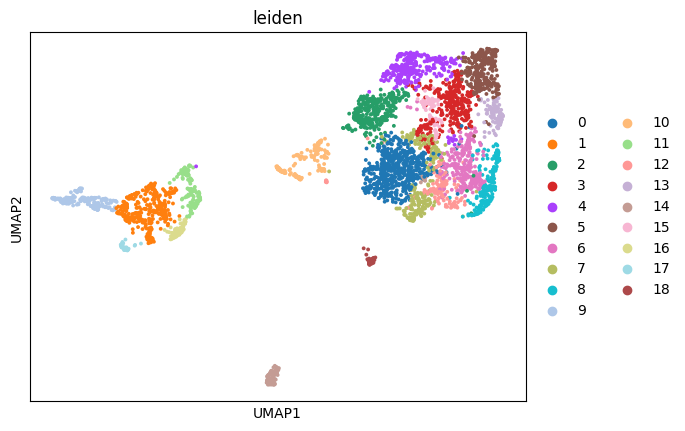

In [32]:
adata = adata_x
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_share')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, show=True, wspace=0.4, ncols=4)

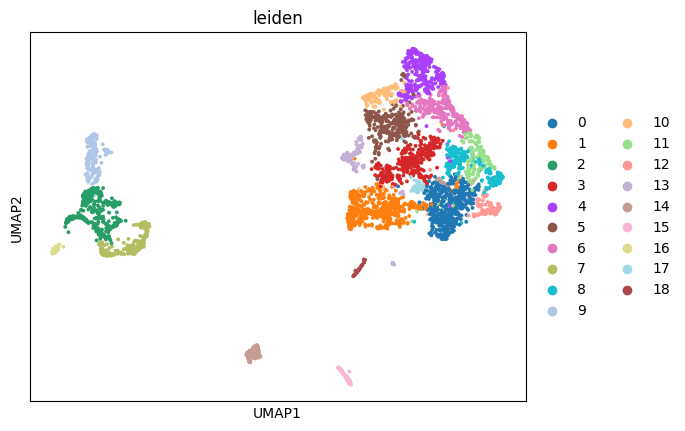

In [20]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_Single')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, show=True, wspace=0.4, ncols=4)

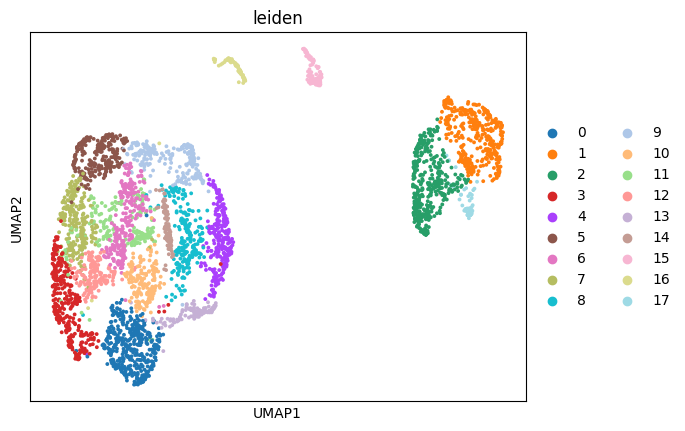

In [21]:
adata = adata_y
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_share')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, show=True, wspace=0.4, ncols=4)

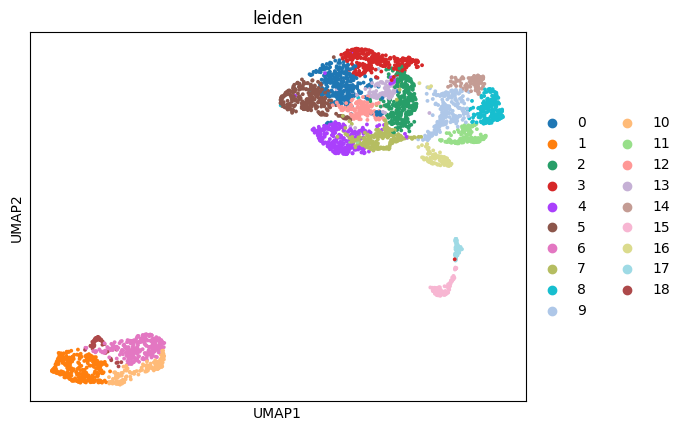

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_single')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, show=True, wspace=0.4, ncols=4)

############

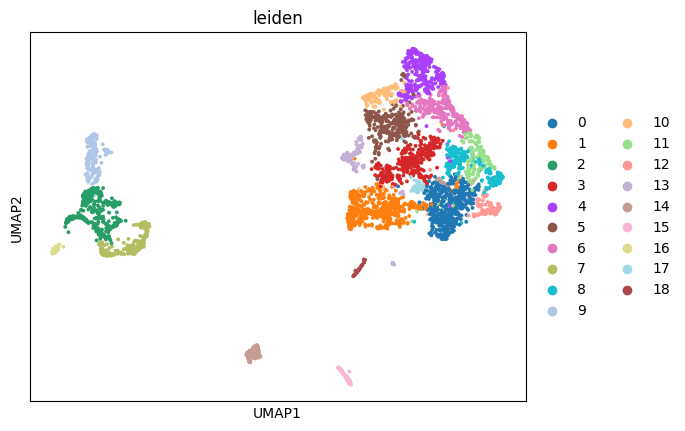

In [24]:
adata = adata_x
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_Single')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, save=file1+"_"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+"_Single_scRNA.pdf", show=True, wspace=0.4, ncols=4)

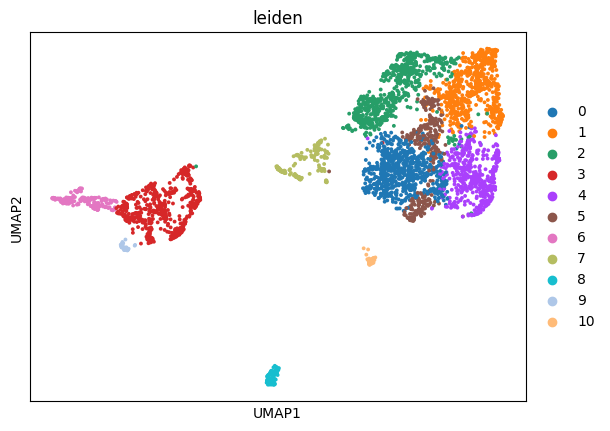

In [25]:
adata = adata_x
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_share')
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['cell_type_rna', 'kmeans', 'leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, save=file1+"_"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+"__Share_scRNA.pdf", show=True, wspace=0.4, ncols=4)

In [59]:
pd.Series(adata.obs.index.values).to_csv(os.path.join(output_path, file1, file1 + '_selectCellid.csv'), index=False)

In [28]:
# save adata.obs['leiden'] to csv
adata.obs['leiden'].to_csv(os.path.join(output_path, file1, file1 + '_Share_scRNA_leiden_clusters.csv'))

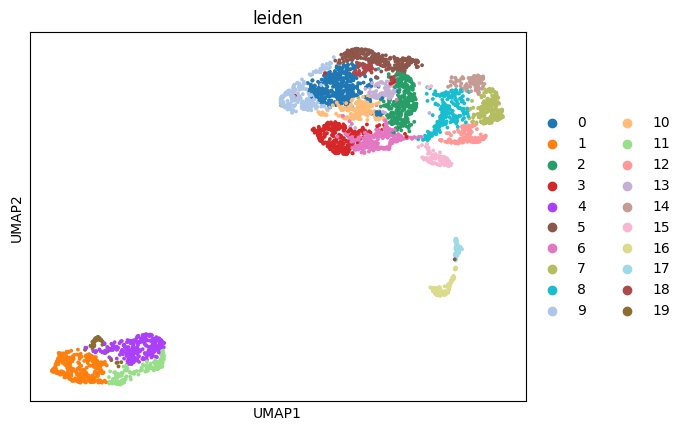

In [26]:
adata = adata_y
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_single')
sc.tl.leiden(adata, resolution=1.1)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, save=file1+"_"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+"_Single_scATAC.pdf", show=True, wspace=0.4, ncols=4)

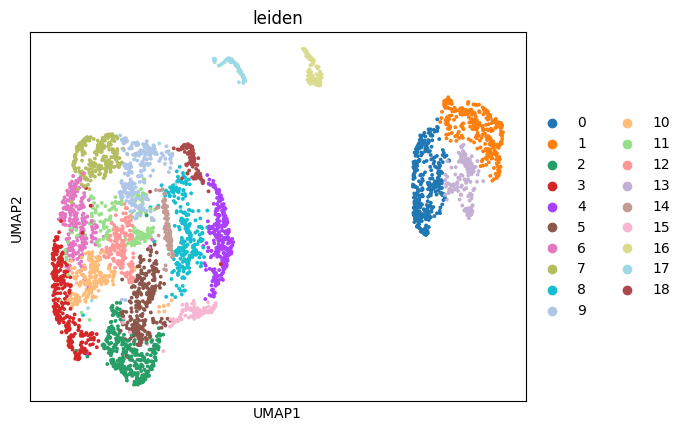

In [27]:
adata = adata_y
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent_share')
sc.tl.leiden(adata, resolution=1.1)
sc.tl.umap(adata, min_dist=0.2)
color = [c for c in ['leiden'] if c in adata.obs]
sc.pl.umap(adata, color=color, save=file1+"_"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+"_Share_scATAC.pdf", show=True, wspace=0.4, ncols=4)

In [29]:
# save adata.obs['leiden'] to csv
adata.obs['leiden'].to_csv(os.path.join(output_path, file1, file1 + '_Share_scATAC_leiden_clusters.csv'))

In [30]:
import pandas as pd

# 假设 adata_y 是你的AnnData对象
# 提取 latent_share 数据
latent_share_data = adata_y.obsm['latent_share']

# 为列名生成一个列表，假设有多个特征
column_names = [f"latent{i+1}" for i in range(latent_share_data.shape[1])]

# 将 numpy array 转换为 DataFrame
latent_share_df = pd.DataFrame(latent_share_data, columns=column_names)

# 设置DataFrame的行名为adata_y.obs中的某个列，假设这个列名是'cell_id'
latent_share_df.index = adata_y.obs.index

# 保存 DataFrame 到 CSV 文件
latent_share_df.to_csv(os.path.join(output_path, file1, file1 + "_latent_share_data_ATAC.csv"))

print("Data saved to 'latent_share_data.csv', with cell IDs and dynamically specified column names.")


Data saved to 'latent_share_data.csv', with cell IDs and dynamically specified column names.


In [3]:
import pandas as pd

# 假设 adata_y 是你的AnnData对象
# 提取 latent_share 数据
latent_share_data = adata_y.obsm['latent_single']

# 为列名生成一个列表，假设有多个特征
column_names = [f"latent{i+1}" for i in range(latent_share_data.shape[1])]

# 将 numpy array 转换为 DataFrame
latent_share_df = pd.DataFrame(latent_share_data, columns=column_names)

# 设置DataFrame的行名为adata_y.obs中的某个列，假设这个列名是'cell_id'
latent_share_df.index = adata_y.obs.index

# 保存 DataFrame 到 CSV 文件
latent_share_df.to_csv(os.path.join(output_path, file1, file1 + "_latent_private_data_ATAC.csv"))

print("Data saved to 'latent_private_data.csv', with cell IDs and dynamically specified column names.")

Data saved to 'latent_private_data.csv', with cell IDs and dynamically specified column names.


In [31]:
import pandas as pd

# 假设 adata_y 是你的AnnData对象
# 提取 latent_share 数据
latent_share_data = adata_x.obsm['latent_share']

# 为列名生成一个列表，假设有多个特征
column_names = [f"latent{i+1}" for i in range(latent_share_data.shape[1])]

# 将 numpy array 转换为 DataFrame
latent_share_df = pd.DataFrame(latent_share_data, columns=column_names)

# 设置DataFrame的行名为adata_y.obs中的某个列，假设这个列名是'cell_id'
latent_share_df.index = adata_x.obs.index

# 保存 DataFrame 到 CSV 文件
latent_share_df.to_csv(os.path.join(output_path, file1, file1 + "_latent_share_data_RNA.csv"))

print("Data saved to 'latent_share_data.csv', with cell IDs and dynamically specified column names.")

Data saved to 'latent_share_data.csv', with cell IDs and dynamically specified column names.
